In [161]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from matplotlib import  pyplot as plt
import requests
import folium
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim
import json
import seaborn as sns
%matplotlib inline

In [74]:
if True:
    new_york = pd.read_csv("./data/new_york.csv")
    toronto = pd.read_csv("./data/toronto.csv")

## create a geolocator object for each city

In [ ]:
raise
# don't run below cell

In [193]:
def get_geolocator(address, agent, verbose=True):
    geoloator = Nominatim(user_agent=agent)
    location = geoloator.geocode(address)
    if location:
        latitude = location.latitude
        longitude = location.longitude
        if verbose:
            print("The geographic coordinate of {} is {}, {}".format(address, latitude, longitude))
        return latitude, longitude
    else:
        return np.nan, np.nan

In [194]:
nyc_location = get_geolocator("New York City, US", "nyc_explorer")

The geographic coordinate of New York City, US is 40.7308619, -73.9871558


In [195]:
yto_location = get_geolocator("Toronto, CA", "yto_explorer")

The geographic coordinate of Toronto, CA is 43.653963, -79.387207


In [5]:
address = 'New York City, US'

geolocator_nyc = Nominatim(user_agent="nyc_explorer")
location_nyc = geolocator_nyc.geocode(address)
latitude_nyc = location_nyc.latitude
longitude_nyc = location_nyc.longitude
print('The geograpical coordinate of San Francisco are {}, {}.'.format(latitude_nyc, longitude_nyc))

The geograpical coordinate of San Francisco are 40.7308619, -73.9871558.


## Scraping the Neighborhoods Lists

In [6]:
NYC = "https://en.wikipedia.org/wiki/Neighborhoods_in_New_York_City"
YTO = "https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Toronto"

In [7]:
def get_content(url):
    page = requests.get(url)
    content = page.content
    soup = BeautifulSoup(content, "lxml")
    # get the data head
    columns = []
    for i in soup.select("table.wikitable")[0].find_all("th"):
        columns.append(i.text.strip())
    # get data
    data = pd.DataFrame(columns=columns)
    index = 0
    for i in soup.select("table.wikitable")[0].find_all("tr")[1:]:
        temp = []
        for item in i.find_all("td"):
            temp.append(item.text.strip())
        if "Not assigned" not in temp:
            data = pd.concat([data, pd.DataFrame(dict(zip(columns, temp)), index=[index])])
            index += 1
    return data

In [8]:
new_york = get_content(NYC)
toronto = get_content(YTO)

In [9]:
toronto.head()

,District Number,Neighbourhoods Included
0,C01,"Downtown, Harbourfront, Little Italy, Little P..."
1,C02,"The Annex, Yorkville, South Hill, Summerhill, ..."
2,C03,"Forest Hill South, Oakwood–Vaughan, Humewood–C..."
3,C04,"Bedford Park, Lawrence Manor, North Toronto, F..."
4,C06,"North York, Clanton Park, Bathurst Manor"


In [10]:
new_york.head()

,Community Board(CB),Areakm2,Pop.Census2010,Pop./km2,Neighborhoods
0,Bronx CB 1,7.17,"91,497","12,761","Melrose, Mott Haven, Port Morris"
1,Bronx CB 2,5.54,"52,246","9,792","Hunts Point, Longwood"
2,Bronx CB 3,4.07,"79,762","19,598","Claremont, Concourse Village, Crotona Park, Mo..."
3,Bronx CB 4,5.28,"146,441","27,735","Concourse, High Bridge"
4,Bronx CB 5,3.55,"128,200","36,145","Fordham, Morris Heights, Mount Hope, Universit..."


In [11]:
toronto = toronto["Neighbourhoods Included"]. \
            str.split(",", expand=True).melt(
                value_name="Neighbourhoods", var_name="index").merge(
                    toronto["District Number"].reset_index(), 
                    on="index", how="left").drop("index", axis=1).dropna(subset=["Neighbourhoods"]) \
            .reset_index(drop=True)

In [12]:
new_york = new_york["Neighborhoods"].str.split(",", expand=True).melt(
    value_name="Neighbourhoods", var_name="index").merge(
        new_york["Community Board(CB)"].reset_index(), on="index",
        how="left").drop("index", axis=1).dropna(how="any").reset_index(drop=True)

In [13]:
toronto.columns = ["Neighbourhoods", "District"]
new_york.columns = ["Neighbourhoods", "Distict"]
toronto["City"] = "YTO"
new_york["City"] = "NYC"

In [14]:
new_york.head()

,Neighbourhoods,Distict,City
0,Melrose,Bronx CB 1,NYC
1,Hunts Point,Bronx CB 1,NYC
2,Claremont,Bronx CB 1,NYC
3,Concourse,Bronx CB 1,NYC
4,Fordham,Bronx CB 1,NYC


In [15]:
# save data
if False:
    new_york.to_csv("./data/new_york.csv", index=False)
    toronto.to_csv("./data/toronto.csv", index=False)

## Query The Neighbourhoods Location

In [ ]:
raise
# don't run below cell

In [16]:
toronto["Latitude"] = toronto.Neighbourhoods.apply(
    lambda x: get_geolocator(x, "yto_explorer", False)[0]
)
toronto["Longitude"] = toronto.Neighbourhoods.apply(
    lambda x: get_geolocator(x, "yto_explorer", False)[1]
)

In [17]:
new_york["Latitude"] = new_york.Neighbourhoods.apply(
    lambda x: get_geolocator(x, "nyc_explorer", False)[0]
)
new_york["Longitude"] = new_york.Neighbourhoods.apply(
    lambda x: get_geolocator(x, "nyc_explorer", False)[1]
)

In [64]:
# save data
if True:
    new_york.to_csv("./data/new_york.csv", index=False)
    toronto.to_csv("./data/toronto.csv", index=False)

In [21]:
new_york.head()

,Neighbourhoods,Distict,City,Latitude,Longitude
0,Melrose,Bronx CB 1,NYC,42.456432,-71.064182
1,Hunts Point,Bronx CB 1,NYC,43.949243,-64.762516
2,Claremont,Bronx CB 1,NYC,34.096676,-117.719779
3,Concourse,Bronx CB 1,NYC,1.301022,103.862493
4,Fordham,Bronx CB 1,NYC,40.859267,-73.898469


In [ ]:
raise

## Get Food Category Information

In [34]:
LIMIT = 500 # limit of number of venues returned by Foursquare API
radius = 2000 # define radius
CLIENT_ID = '2G3RU0HVXD2R2MVA0VS3VOXRUB3OBP2SAOXL1E5CNCQZKAPS'
CLIENT_SECRET = '3WJ2JCHLUD52FNDERTYH0FFHVROWIRRM3QJ1Z0JWW5THTXCF'
VERSION = '20181020'
categoryFood = "4d4b7105d754a06374d81259"
categorySchool = "4bf58dd8d48988d13d941735"

In [23]:
def getNearbyVenues(name, latitude, longitude, radius=2000, category=""):
    url = 'https://api.foursquare.com/v2/venues/search?&radius={}&'.format(radius)
    expand_infor = "client_id={}&client_secret={}&v={}&ll={},{}&limit={}".format(
        CLIENT_ID, CLIENT_SECRET, VERSION, latitude, longitude, LIMIT
    )
    
    if category:
        category_infor = "&categoryId={}".format(category)
    else:
        category_infor = ""
    # merge the url
    url = url + expand_infor + category_infor
    
    
    # extract infromation
    response = requests.get(url).json()
    
    return response

In [25]:
new_york.loc[0:2, :]

,Neighbourhoods,Distict,City,Latitude,Longitude
0,Melrose,Bronx CB 1,NYC,42.456432,-71.064182
1,Hunts Point,Bronx CB 1,NYC,43.949243,-64.762516
2,Claremont,Bronx CB 1,NYC,34.096676,-117.719779


In [3]:
toronto.loc[0:2]

,Neighbourhoods,District,City,Latitude,Longitude,CategoryFood,CategorySchool
0,Downtown,C01,YTO,1.279191,103.853345,"{'meta': {'code': 200, 'requestId': '5c9ca3333...","{'meta': {'code': 200, 'requestId': '5c9ca5354..."
1,The Annex,C01,YTO,43.670338,-79.407117,"{'meta': {'code': 200, 'requestId': '5c9ca3333...","{'meta': {'code': 200, 'requestId': '5c9ca5359..."
2,Forest Hill South,C01,YTO,59.409745,13.583393,"{'meta': {'code': 200, 'requestId': '5c9ca3339...","{'meta': {'code': 200, 'requestId': '5c9ca5356..."


In [35]:
# use the api to get category food
new_york["CategoryFood"] = new_york.apply(lambda x: getNearbyVenues(
        x["Neighbourhoods"], x["Latitude"], x["Longitude"], category=categoryFood
    ), axis=1)

toronto["CategoryFood"] = toronto.apply(lambda x: getNearbyVenues(
        x["Neighbourhoods"], x["Latitude"], x["Longitude"], category=categoryFood
    ), axis=1)

In [37]:
# use the api to get school infor
new_york["CategorySchool"] = new_york.apply(lambda x: getNearbyVenues(
        x["Neighbourhoods"], x["Latitude"], x["Longitude"], category=categorySchool
    ), axis=1)

toronto["CategorySchool"] = toronto.apply(lambda x: getNearbyVenues(
        x["Neighbourhoods"], x["Latitude"], x["Longitude"], category=categorySchool
    ), axis=1)

## Parse School Information & Food Information

In [79]:
def get_category(x, target="category"):
    """
    parameters:
    ----------
    target: string, default category
        Choose target information. Like category, name, location
    """
    information = dict(
        Name = [],
        Location = [],
        Category = []
        )
    if "response" not in x or "venues" not in x["response"]:
        return np.nan
    for item in x["response"]["venues"]:
        name = item["name"]
        location = (item["location"]["lat"], item["location"]["lng"])
        category = item["categories"][0]["name"]
        
        if name and location and category:
            information["Name"].append(name)
            information["Location"].append(location)
            information["Category"].append(category)
    if target == "category":
        return information["Category"]
    elif target == "name":
        return information["Name"]
    elif target == "location":
        return information["Location"]
    elif target in ["all", ""]:
        return information

In [83]:
new_york["FoodInformation"] = new_york.CategoryFood.apply(get_category, target="all")
toronto["FoodInformation"] = toronto.CategoryFood.apply(get_category, target="all")

In [130]:
new_york["SchoolInformation"] = new_york.CategorySchool.apply(get_category, target="all")
toronto["SchoolInformation"] = toronto.CategorySchool.apply(get_category, target="all")

In [86]:
new_york.head()

,Neighbourhoods,Distict,City,Latitude,Longitude,CategoryFood,CategorySchool,FoodInformation,CategoryInformation
0,Melrose,Bronx CB 1,NYC,42.456432,-71.064182,"{'meta': {'code': 200, 'requestId': '5c9ca2f26...","{'meta': {'code': 200, 'requestId': '5c9ca5041...","{'Name': ['Starbucks', 'Bruegger's Bagels', 'W...","{'Name': ['Melrose high school', 'Melrose High..."
1,Hunts Point,Bronx CB 1,NYC,43.949243,-64.762516,"{'meta': {'code': 200, 'requestId': '5c9ca2f24...","{'meta': {'code': 200, 'requestId': '5c9ca5041...","{'Name': ['Seaside Seafood Restaurant', 'Ellio...","{'Name': [], 'Location': [], 'Category': []}"
2,Claremont,Bronx CB 1,NYC,34.096676,-117.719779,"{'meta': {'code': 200, 'requestId': '5c9ca2f23...","{'meta': {'code': 200, 'requestId': '5c9ca5043...","{'Name': ['Dr. Grubb's', 'The Back Abbey', 'Gr...","{'Name': ['San Antonio high school', 'Claremon..."
3,Concourse,Bronx CB 1,NYC,1.301022,103.862493,"{'meta': {'code': 200, 'requestId': '5c9ca2f21...","{'meta': {'code': 200, 'requestId': '5c9ca5041...",{'Name': ['Golden Mile (Beach Road) Food Centr...,"{'Name': ['F4-5 @ GMSS', 'Rezekiku', 'Dunman H..."
4,Fordham,Bronx CB 1,NYC,40.859267,-73.898469,"{'meta': {'code': 200, 'requestId': '5c9ca2f33...","{'meta': {'code': 200, 'requestId': '5c9ca5041...","{'Name': ['Lee's Delicatessen', 'Dunkin Donuts...",{'Name': ['Theatre Arts Production Company Sch...


In [108]:
toronto.head()

,Neighbourhoods,District,City,Latitude,Longitude,CategoryFood,CategorySchool,FoodInformation,CategoryInformation
0,Downtown,C01,YTO,1.279191,103.853345,"{'meta': {'code': 200, 'requestId': '5c9ca3333...","{'meta': {'code': 200, 'requestId': '5c9ca5354...",{'Name': ['LeVeL 33 Craft-Brewery Restaurant &...,"{'Name': ['SAF', 'Heritage Room', 'The Only Bo..."
1,The Annex,C01,YTO,43.670338,-79.407117,"{'meta': {'code': 200, 'requestId': '5c9ca3333...","{'meta': {'code': 200, 'requestId': '5c9ca5359...","{'Name': ['Famoso Neapolitan Pizzeria', 'McCaf...","{'Name': ['Royal St George's', 'RSGC', 'The Ab..."
2,Forest Hill South,C01,YTO,59.409745,13.583393,"{'meta': {'code': 200, 'requestId': '5c9ca3339...","{'meta': {'code': 200, 'requestId': '5c9ca5356...","{'Name': ['Café Selma', 'Solsta Inn', 'Alsters...","{'Name': ['Frödingskolan', 'Staff Rm'], 'Locat..."
3,Bedford Park,C01,YTO,43.737388,-79.410925,"{'meta': {'code': 200, 'requestId': '5c9ca3334...","{'meta': {'code': 200, 'requestId': '5c9ca5356...","{'Name': ['The Miller Tavern', 'George's Indep...","{'Name': ['Loretto Abbey CSS', 'Alpha II Alter..."
4,North York,C01,YTO,43.770817,-79.413300,"{'meta': {'code': 200, 'requestId': '5c9ca3349...","{'meta': {'code': 200, 'requestId': '5c9ca5354...","{'Name': ['Pho 88 Vietnamese Cuisine', 'Aroma ...","{'Name': ['Earl Haig Secondary School', 'James..."


In [132]:
# save the data
if False:
    new_york.to_csv("./data/new_york.csv", index=False)
    toronto.to_csv("./data/toronto.csv", index=False)

## Merge Data & Wrangling Data

In [133]:
raw_data = new_york.append(toronto, ignore_index=True, sort=False)

In [134]:
raw_data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462 entries, 0 to 461
Data columns (total 9 columns):
Neighbourhoods       461 non-null object
District             462 non-null object
City                 462 non-null object
Latitude             439 non-null float64
Longitude            439 non-null float64
CategoryFood         462 non-null object
CategorySchool       462 non-null object
FoodInformation      439 non-null object
SchoolInformation    439 non-null object
dtypes: float64(2), object(7)
memory usage: 32.6+ KB


In [135]:
foodtype = set()
for i in raw_data.FoodInformation:
    if pd.notna(i):
        foodtype.update(set(i["Category"]))

In [136]:
foodtype = pd.Series(list(foodtype))
for column in foodtype[foodtype.str.contains("Restaurant", case=False)]:
    raw_data[column] = raw_data.FoodInformation.apply(lambda x: x["Category"].count(column) if pd.notna(x) else 0)

In [137]:
schooltype = set()
for i in raw_data.SchoolInformation:
    if pd.notna(i):
        schooltype.update(set(i["Category"]))

In [146]:
schooltype = pd.Series(list(schooltype))
for column in schooltype[schooltype.str.contains("College|Elementary|School|University", case=False)]:
    raw_data[column] = raw_data.FoodInformation.apply(lambda x: x["Category"].count(column) if pd.notna(x) else 0)

In [147]:
raw_data.head()

,Neighbourhoods,District,City,Latitude,Longitude,CategoryFood,CategorySchool,FoodInformation,SchoolInformation,Afghan Restaurant,...,College Arts Building,Religious School,High School,College Classroom,General College & University,College Quad,School,College Technology Building,Elementary School,Private School
0,Melrose,Bronx CB 1,NYC,42.456432,-71.064182,"{'meta': {'code': 200, 'requestId': '5c9ca2f26...","{'meta': {'code': 200, 'requestId': '5c9ca5041...","{'Name': ['Starbucks', 'Bruegger's Bagels', 'W...","{'Name': ['Melrose high school', 'Melrose High...",0,...,0,0,0,0,0,0,0,0,0,0
1,Hunts Point,Bronx CB 1,NYC,43.949243,-64.762516,"{'meta': {'code': 200, 'requestId': '5c9ca2f24...","{'meta': {'code': 200, 'requestId': '5c9ca5041...","{'Name': ['Seaside Seafood Restaurant', 'Ellio...","{'Name': [], 'Location': [], 'Category': []}",0,...,0,0,0,0,0,0,0,0,0,0
2,Claremont,Bronx CB 1,NYC,34.096676,-117.719779,"{'meta': {'code': 200, 'requestId': '5c9ca2f23...","{'meta': {'code': 200, 'requestId': '5c9ca5043...","{'Name': ['Dr. Grubb's', 'The Back Abbey', 'Gr...","{'Name': ['San Antonio high school', 'Claremon...",0,...,0,0,0,0,0,0,0,0,0,0
3,Concourse,Bronx CB 1,NYC,1.301022,103.862493,"{'meta': {'code': 200, 'requestId': '5c9ca2f21...","{'meta': {'code': 200, 'requestId': '5c9ca5041...",{'Name': ['Golden Mile (Beach Road) Food Centr...,"{'Name': ['F4-5 @ GMSS', 'Rezekiku', 'Dunman H...",0,...,0,0,0,0,0,0,0,0,0,0
4,Fordham,Bronx CB 1,NYC,40.859267,-73.898469,"{'meta': {'code': 200, 'requestId': '5c9ca2f33...","{'meta': {'code': 200, 'requestId': '5c9ca5041...","{'Name': ['Lee's Delicatessen', 'Dunkin Donuts...",{'Name': ['Theatre Arts Production Company Sch...,0,...,0,0,0,0,0,0,0,0,0,0


In [149]:
# store data
raw_data.to_csv("./data/raw_data.csv", index=False)

## Display Information

In [156]:
restaurant = raw_data.groupby("City")[
    raw_data.columns[raw_data.columns.str.contains("Restaurant", case=False)]
].sum().reset_index()

In [160]:
restaurant = restaurant.melt(id_vars=["City"], 
               value_vars=raw_data.columns[raw_data.columns.str.contains("Restaurant", case=False)], 
                value_name="Total", var_name="Type")

In [191]:
raw_data.groupby("City")[
    raw_data.columns[raw_data.columns.str.contains("Restaurant", case=False)]
].sum().T.sort_values(by=["NYC", "YTO"], ascending=False).head(20)

City,NYC,YTO
Fast Food Restaurant,907,403
American Restaurant,530,118
Italian Restaurant,484,132
Chinese Restaurant,388,146
Mexican Restaurant,354,85
Restaurant,229,151
Seafood Restaurant,162,26
Sushi Restaurant,150,57
Caribbean Restaurant,133,50
Indian Restaurant,122,93


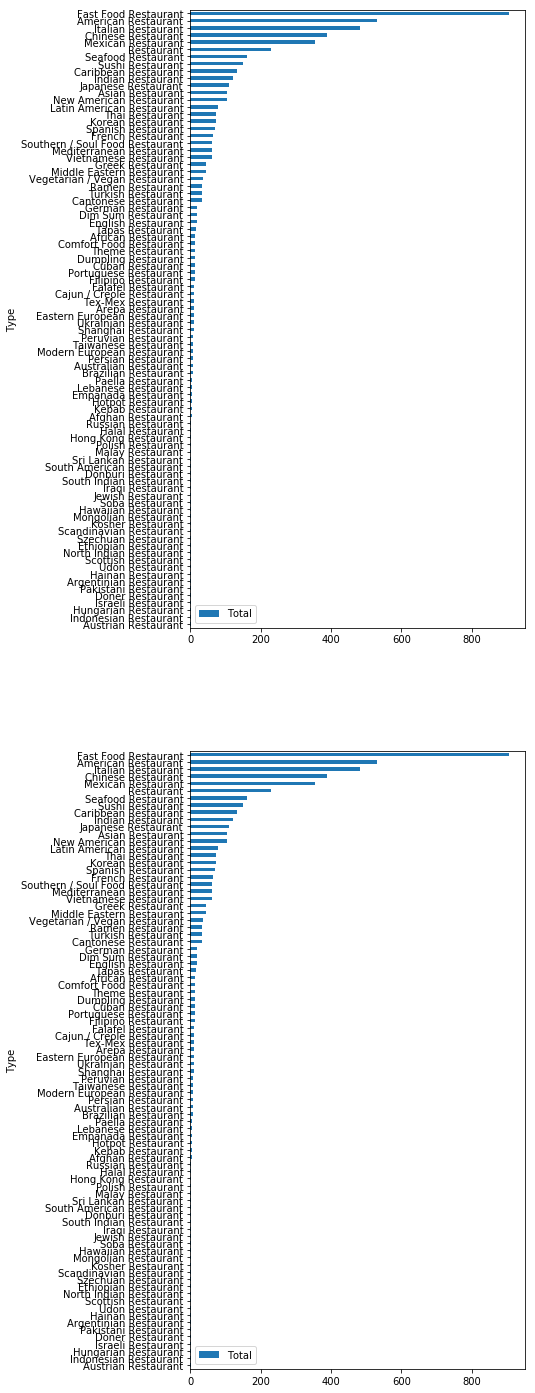

In [181]:
_, ax = plt.subplots(nrows=2, ncols=1, figsize=(6, 25))
restaurant[(restaurant.City == "NYC") & (restaurant.Total > 0)].sort_values("Total").plot(
    x="Type", y="Total", kind="barh", ax=ax[0]
)
restaurant[(restaurant.City == "NYC") & (restaurant.Total > 0)].sort_values("Total").plot(
    x="Type", y="Total", kind="barh", ax=ax[1]
)
plt.show()

## Map Information

In [197]:
raw_data["AllRestaurant"] = raw_data[
    raw_data.columns[raw_data.columns.str.contains("Restaurant", case=False)]
].sum(axis=1)

In [198]:
raw_data.head(2)

,Neighbourhoods,District,City,Latitude,Longitude,CategoryFood,CategorySchool,FoodInformation,SchoolInformation,Afghan Restaurant,...,Religious School,High School,College Classroom,General College & University,College Quad,School,College Technology Building,Elementary School,Private School,AllRestaurant
0,Melrose,Bronx CB 1,NYC,42.456432,-71.064182,"{'meta': {'code': 200, 'requestId': '5c9ca2f26...","{'meta': {'code': 200, 'requestId': '5c9ca5041...","{'Name': ['Starbucks', 'Bruegger's Bagels', 'W...","{'Name': ['Melrose high school', 'Melrose High...",0,...,0,0,0,0,0,0,0,0,0,19
1,Hunts Point,Bronx CB 1,NYC,43.949243,-64.762516,"{'meta': {'code': 200, 'requestId': '5c9ca2f24...","{'meta': {'code': 200, 'requestId': '5c9ca5041...","{'Name': ['Seaside Seafood Restaurant', 'Ellio...","{'Name': [], 'Location': [], 'Category': []}",0,...,0,0,0,0,0,0,0,0,0,3


In [203]:
data= raw_data.dropna(subset=["Latitude"])

In [207]:
data.FoodInformation.apply(lambda x: x["Location"])

0      [(42.45541397, -71.06494986), (42.455259329668...
1      [(43.95244037766659, -64.78053259364606), (43....
2      [(34.09671638661277, -117.71871151849997), (34...
3      [(1.3031448975009932, 103.8640100461901), (1.2...
4      [(40.8611160866916, -73.89690167642789), (40.8...
5      [(55.899486, -3.638566), (55.90035629272461, -...
6      [(43.74083522055517, -79.40572871344881), (43....
7      [(40.89121949532642, -73.89788103173487), (40....
8      [(41.073054, -73.771477), (41.07350356586335, ...
9      [(40.847237825113424, -73.78624488983156), (40...
10     [(53.804407, -1.820811), (53.805384782288435, ...
11     [(40.86584304086998, -73.83770669702484), (40....
12                                                    []
13     [(40.68650187272256, -73.98515046129243), (40....
14     [(52.36375791746219, 4.935791556690879), (52.3...
15     [(40.69862080770456, -73.91858786344534), (40....
16     [(40.67554202148138, -73.89014873800367), (40....
17     [(40.67919367815675, -73

In [204]:
mapinfo = folium.Map(location=[(nyc_location[0] + yto_location[0])/2, 
                                  (nyc_location[1] + yto_location[1])/2], zoom_start=12)

# add markers to map
for lat, lng, local, cir in zip(data['Latitude'], data['Longitude'], data['Neighbourhoods'], data["AllRestaurant"]):
    label = '{}'.format(local)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=cir,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(mapinfo)  
    
mapinfo